# Project 2: Reproducibility in Natural Language Processing



### Read Data and Import

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-dark')

In [2]:
#Loading in data
sou = pd.read_csv("data/SOTU.csv")

In [3]:
# Importing packages
import spacy
from tqdm import tqdm
from collections import Counter

nlp = spacy.load("en_core_web_sm")

## Part 4: Choose your own advecnture! (7 Points; Optional for Extra Credit)

Here, we look at how word frequencies for specific words change over time.

As we think it is more intuitive to work in Python dictionaries, these will be used here, and not the Dictionary class from gensim.

### Computing word frequencies by year

Processing speeches, and storing them in a dictionary

In [4]:
speeches_by_year = {}

for year, speech in tqdm(zip(sou["Year"], sou["Text"]), total=len(sou)):
    if year not in speeches_by_year:
        speeches_by_year[year] = []
    speeches_by_year[year].append(nlp(speech))

100%|██████████| 246/246 [04:53<00:00,  1.19s/it]


Pulling lemmas from the speeches, and flattening so that we only have one list of lemmas for each year

In [5]:
# Defining function to pull lemmas from a speech
# (basically the same as the preprocess function from part 3)
def speech_to_lemmas(speech):
    return [
        token.lemma_.lower()
        for token in speech
        if not token.is_stop and not token.is_punct and not token.is_space
    ]

# Merge all lemmas from speeches in the same year into one single list
lemmas_by_year = {}
for year, speeches in speeches_by_year.items():
    all_lemmas = []
    for speech in speeches:
        all_lemmas.extend(speech_to_lemmas(speech))

    lemmas_by_year[year] = all_lemmas

Counting the amount of lemmas per year

In [6]:
# Total number of lemmas per year
years = sorted(lemmas_by_year.keys())
year_counts = {year: Counter(lemmas_by_year[year]) for year in years}

# We also define the total number of lemma counts to use below
overall_counts = sum(year_counts.values(), Counter())

# Keep only the lemmas that are not too rare
keep_lemmas = [lemma for lemma, i in overall_counts.items() if i >= 50]

### Deciding on which words to plot

Finding interesting words by fitting a linear regression for each lemma and then choosing the lemmas with the smallest and highest slope, hoping to see something interesting

In [7]:
changes_lemmas = []
for lemma in keep_lemmas:
    lemma_counts_per_year = [year_counts[year].get(lemma) for year in years]
    lemma_counts_per_year = [0 if count is None else count for count in lemma_counts_per_year]

    # We require that the word appears a few different years
    if sum(i > 0 for i in lemma_counts_per_year) < 5:
        continue

    # Look a the slope when fitting a linear regression 
    x = np.arange(len(years))
    y = np.array(lemma_counts_per_year)
    slope, intercept = np.polyfit(x, y, 1)

    changes_lemmas.append((lemma, slope))

# Sort the slopes of the lemmas
changes_lemmas.sort(key=lambda x: x[1])

# Keeping the top declining and rising words
interesting_lemmas = [lemma for lemma, slope in changes_lemmas[-2:]]
interesting_lemmas.extend([lemma for lemma, change in changes_lemmas[:2]])

### Plotting

Below, the two lemmas with the highest and the two lemmas with the lowest slope are plotted

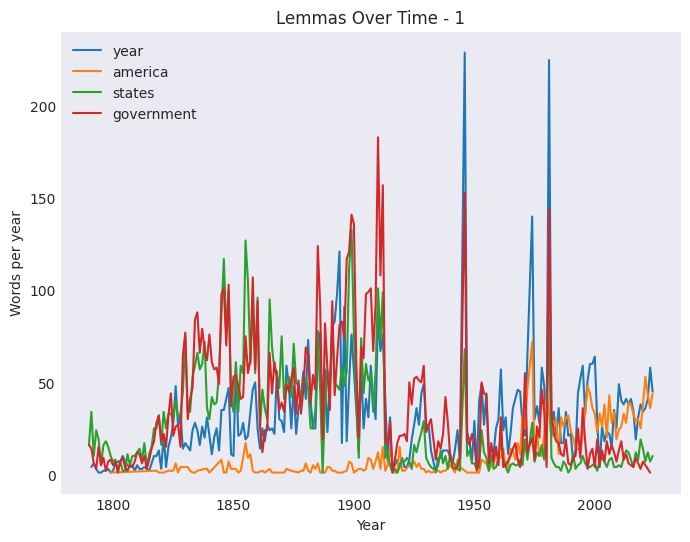

<Figure size 640x480 with 0 Axes>

In [8]:
plt.figure(figsize=(8, 6))

# Calculating the count for each of the interesting lemmas for each year
for lemma in interesting_lemmas:
    counts = [year_counts[year].get(lemma) for year in years]
    sns.lineplot(x=years, y=counts, label=lemma)

plt.title('Lemmas Over Time - 1')
plt.xlabel('Year')
plt.ylabel('Words per year')
plt.legend()
plt.show()
plt.savefig("outputs/4.1_Lemmas_Over_Time_1.png", dpi=300, bbox_inches='tight')

The problem with this method is that we only look at the average slope across all of the years and determine which lemmas have significant change based on this. There would be better ways to determine interesting shifts in lemmas.

### Qualitative Reasoning
Below, lemmas have been selected qualitatively based on general knowledge of the US.

In [9]:
interesting_lemmas_qualitative = ['agriculture', 'economy', 'constitution']

### Plotting

Below, we plot the qualitatively chosen lemmas.

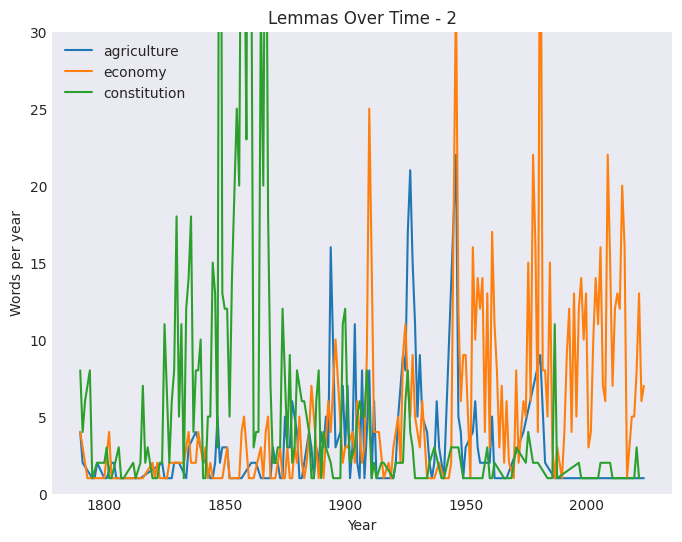

<Figure size 640x480 with 0 Axes>

In [10]:
plt.figure(figsize=(8, 6))

# Calculating the count for each of the interesting lemmas for each year
for lemma in interesting_lemmas_qualitative:
    counts = [year_counts[year].get(lemma) for year in years]
    sns.lineplot(x=years, y=counts, label=lemma)

plt.title('Lemmas Over Time - 2')
plt.xlabel('Year')
plt.ylabel('Words per year')
plt.ylim(0,30)
plt.legend()
plt.show()
plt.savefig("outputs/4.2_Lemmas_Over_Time_2.png", dpi=300, bbox_inches='tight')

The shift in language over time becomes clear. Terms like "agriculture" are prominent around 1900 and again during the 1920–1930 period, reflecting the political focus on farming at the time.

Meanwhile, "constitution" appears far more frequently in the earlier decades, with its use declining after 1880.

In contrast, "economy" - despite a few spikes earlier - only becomes a consistently popular term starting around 1950, showing how the modern economy becomes a central political theme.